# Processing 1: AnyLoc VLAD DINOv2 Descriptors


In [1]:
import os
import requests
if os.path.isfile('utilities.py'):
    print('Found utilities.py')
else:
    print("Could not find utilities.py, downloading it")
    url = "https://raw.githubusercontent.com/AnyLoc/AnyLoc/main/demo/utilities.py"
    file_data = requests.get(url, allow_redirects=True)
    with open('utilities.py', 'wb') as handler:
        handler.write(file_data.content)

Found utilities.py


In [2]:
#!pip install gdown

In [3]:
from onedrivedownloader import download

In [4]:
import gdown

cache_url = 'https://drive.google.com/uc?id=1ZYcm1rUY1sTZmMWstYCoG4543U_8N3n8'
output_cache = 'cache.zip'

gdown.download(cache_url, output_cache, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ZYcm1rUY1sTZmMWstYCoG4543U_8N3n8
From (redirected): https://drive.google.com/uc?id=1ZYcm1rUY1sTZmMWstYCoG4543U_8N3n8&confirm=t&uuid=44fa6363-d147-4810-96f8-a5c54879ac7c
To: C:\Users\totmi\MyProjects\anyloc_new\cache.zip
100%|██████████| 184M/184M [00:17<00:00, 10.5MB/s] 


'cache.zip'

In [5]:
test = 'https://drive.google.com/uc?id=1tZ3Rut2eowCakvKy1V4GbiDEvUDe0Aws'

output_test = 'tests.zip'

gdown.download(test, output_test, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tZ3Rut2eowCakvKy1V4GbiDEvUDe0Aws
To: C:\Users\totmi\MyProjects\anyloc_new\tests.zip
100%|██████████| 6.55M/6.55M [00:01<00:00, 6.32MB/s]


'tests.zip'

In [6]:
print("Verifying NVIDIA GPU is available")
!nvidia-smi -L
print("Please see that the GPU has at least 16 GB VRAM free")
!nvidia-smi

Verifying NVIDIA GPU is available
GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-3c66b3b5-a485-cb5b-4ba1-1a1425a8d5f8)Please see that the GPU has at least 16 GB VRAM free

Tue Apr  2 21:07:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   46C    P8             26W /  420W |     520MiB /  24576Mi

Ensure that packages are installed

In [7]:
# Install other things
print("Trying to access utility libraries")
try:
    import einops
    import fast_pytorch_kmeans
    import distinctipy
    print("Can access utility libraries")
except ImportError:
    print("Installing utility libraries")
    !pip install fast_pytorch_kmeans
    !pip install einops
    !pip install distinctipy
    !pip install onedrivedownloader

Trying to access utility libraries
Can access utility libraries


#### Downloading Data

Downloading

- `cache`: Vocabulary (cluster centers) and test images
- `tests`: Test data
- `data`: Images that we'll use for testing


In [8]:
# Download and unzip
from utilities import od_down_links
# Link
ln = od_down_links["cache"]
if os.path.isdir("./cache"):
    print("Cache folder already exists!")
else:
    print("Downloading the cache folder")
    download(ln, filename="cache.zip", unzip=True, unzip_path="./")
    print("Cache folder downloaded")

Cache folder already exists!


In [9]:
if os.path.isdir("./tests"):
    print("Tests folder already exists!")
else:
    print("Downloading the tests folder")
    download(ln, filename="tests.zip", unzip=True, unzip_path="./")
    print("Tests folder downloaded")

Tests folder already exists!


In [10]:
import shutil

In [11]:
import os
from PIL import Image

def load_images_from_folder(folder):
    images = []
    folder_path = os.path.join('cache', 'imgs', 'indoor', folder)
    # Getting a list of files in the current folder
    files = os.listdir(folder_path)
    # Go through each file in the current folder
    for file in files:
        # Full path to the current file
        file_path = os.path.join(folder_path, file)
        image = Image.open(file_path)
        images.append(image)
    return images

# Paths to image folders
folders = ['Kitchen', 'Living_room', 'Bathroom', 'Bedroom', 'Wardrobe']

# List to store uploaded images and their labels
images = []
labels = []

# Create separate lists for each image category
images_Kitchen = []
images_Living_room = []
images_Bathroom = []
images_Bedroom = []
images_Wardrobe = []

for folder in folders:
    folder_images = load_images_from_folder(folder)
    images.extend(folder_images)
    labels.extend([folder] * len(folder_images))
    # Add uploaded images to the appropriate lists for each category
    if folder == 'Kitchen':
        images_Kitchen.extend(folder_images)
    elif folder == 'Living_room':
        images_Living_room.extend(folder_images)
    elif folder == 'Bathroom':
        images_Bathroom.extend(folder_images)
    elif folder == 'Bedroom':
        images_Bedroom.extend(folder_images)
    elif folder == 'Wardrobe':
        images_Wardrobe.extend(folder_images)

# Displaying information about the number of uploaded images in each category
print(f"Loaded {len(images_Kitchen)} images for Kitchen.")
print(f"Loaded {len(images_Living_room)} images for Living Room.")
print(f"Loaded {len(images_Bathroom)} images for Bathroom.")
print(f"Loaded {len(images_Bedroom)} images for Bedroom.")
print(f"Loaded {len(images_Wardrobe)} images for Wardrobe.")

Loaded 50 images for Kitchen.
Loaded 50 images for Living Room.
Loaded 50 images for Bathroom.
Loaded 50 images for Bedroom.
Loaded 50 images for Wardrobe.


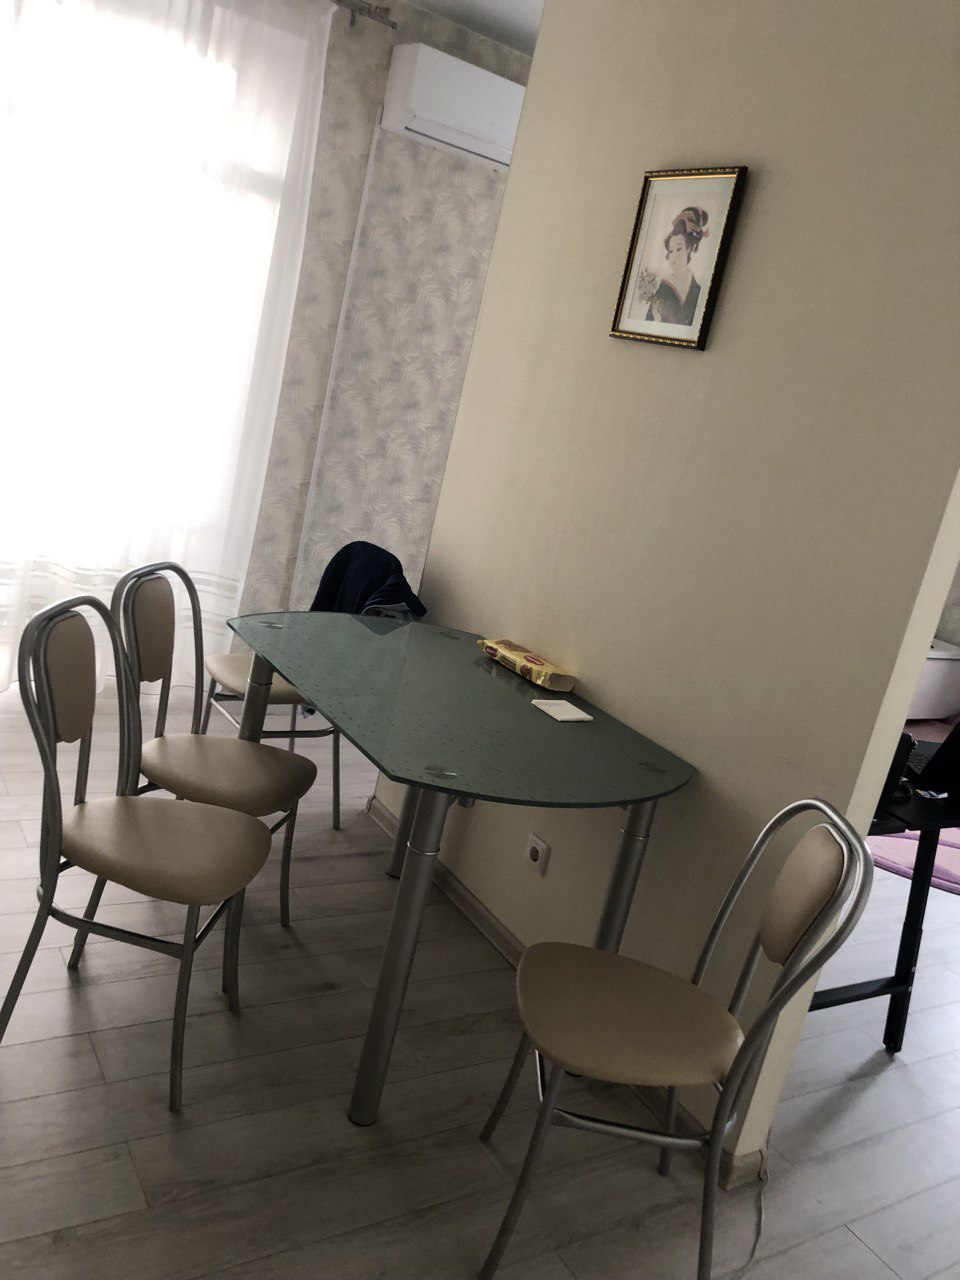

In [12]:
images_Kitchen[25]

In [13]:
import os
import glob

# Checking and displaying information about the number of images in a folder
def check_image_folders(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        assert os.path.isdir(folder_path), f"{folder_path} not found"
        num_imgs = len(glob.glob(f"{folder_path}/*.jpg"))
        if len(glob.glob(f"{folder_path}/*.JPG")) > 0:  # check if there are any images with the extension.JPG
            num_imgs += len(glob.glob(f"{folder_path}/*.JPG"))

base_path = os.path.realpath(os.path.expanduser("./cache/imgs/indoor"))

# List of folders with photos
folders = ['Kitchen', 'Living_room', 'Bathroom', 'Bedroom', 'Wardrobe']

check_image_folders(base_path, folders)

In [14]:
#!pip install natsort
#!pip install opencv-python
#!pip install scikit-learn

### Import Everything

In [15]:
# Import everything
import numpy as np
import cv2 as cv
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tvf
from torchvision.transforms import functional as T
from PIL import Image
import matplotlib.pyplot as plt
import distinctipy as dipy
from tqdm.auto import tqdm
from typing import Literal, List
import os
import natsort
from copy import deepcopy
# DINOv2 imports
from utilities import DinoV2ExtractFeatures
from utilities import VLAD

C:\Users\totmi\anaconda\envs\anyloc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Building Global Descriptors

Save global descriptors as numpy arrays to a directory (mirroring the directory structure of the dataset).


In [16]:
def get_save_path(category: str, base_dir: str) -> str:
    return os.path.join(base_dir, category)

categories = ['Kitchen', 'Living_room', 'Bathroom', 'Bedroom', 'Wardrobe']
base_dir = os.path.expanduser("~/cache/new_rooms")  # Using the home directory

for category in categories:
    save_path = get_save_path(category, base_dir)
    print(f"Images from {category} will be saved in {save_path}")

    if not os.path.isdir(save_path):
        os.makedirs(save_path)
        print(f"Creating directory: {save_path}")
    else:
        print("Save directory already exists, overwriting possible!")

device = torch.device("cuda")

# Dino_v2 parameters
desc_layer: int = 31
desc_facet: Literal["query", "key", "value", "token"] = "value"
num_c: int = 8
# Domain for use case (deployment environment)
domain: Literal["indoor"] = "indoor"
# Maximum image dimension
max_img_size: int = 1024

Images from Kitchen will be saved in C:\Users\totmi/cache/new_rooms\Kitchen
Save directory already exists, overwriting possible!
Images from Living_room will be saved in C:\Users\totmi/cache/new_rooms\Living_room
Save directory already exists, overwriting possible!
Images from Bathroom will be saved in C:\Users\totmi/cache/new_rooms\Bathroom
Save directory already exists, overwriting possible!
Images from Bedroom will be saved in C:\Users\totmi/cache/new_rooms\Bedroom
Save directory already exists, overwriting possible!
Images from Wardrobe will be saved in C:\Users\totmi/cache/new_rooms\Wardrobe
Save directory already exists, overwriting possible!


In [17]:
#model_path = "./cache/vocabulary/dinov2_vitg14/l31_value_c32/indoor/c_centers.pt"

# Loading the model
#model = torch.load(model_path)

# Output of the model structure
#print(model)

In [18]:
#!pip install vit-pytorch

### DINOv2 Extractor

DINOv2 extractor and the base transformation (for each image)

In [19]:
# DINO extractor
if "extractor" in globals():
    print(f"Extractor already defined, skipping")
else:
    extractor = DinoV2ExtractFeatures("dinov2_vitg14", desc_layer,
        desc_facet, device=device)
# Base image transformations
base_tf = tvf.Compose([
    tvf.ToTensor(),
    tvf.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
])

Using cache found in C:\Users\totmi/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\totmi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\totmi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\totmi/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


### VLAD object

For forming global descriptors. Also loads the cluster centers (vocabulary) for VLAD.


In [20]:
cache_dir = './cache'
ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
c_centers_file = os.path.join(cache_dir, "vocabulary", ext_specifier,
                            domain, "c_centers.pt")
assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
c_centers = torch.load(c_centers_file)
assert c_centers.shape[0] == num_c, "Wrong number of clusters!"

In [21]:
# VLAD object
vlad = VLAD(num_c, desc_dim=None,
        cache_dir=os.path.dirname(c_centers_file))
# Fit (load) the cluster centers (this'll also load the desc_dim)
vlad.fit(None)

Using cached cluster centers
Desc dim set to 1536


### Global Descriptor Generation

Main generation stage. Creating global descriptors for 30 images.

In [22]:
img_fnames = []

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    img_fnames.extend(glob.glob(f"{folder_path}/*.jpg"))
    # Добавляем обработку файлов с расширением .JPG
    jpg_files = glob.glob(f"{folder_path}/*.JPG")
    for jpg_file in jpg_files:
        img_fnames.append(jpg_file) if jpg_file.lower().endswith('.jpg') else None

img_fnames = natsort.natsorted(img_fnames)

# Processing photos in each folder (no more than 50 for a room)
for img_fname in tqdm(img_fnames[:50 * len(folders)]):
    # DINO features
    with torch.no_grad():
        pil_img = Image.open(img_fname).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            c, h, w = img_pt.shape
            # Maintain the aspect ratio
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w),
                             interpolation=T.InterpolationMode.BICUBIC)
            print(f"Resized {img_fname} to {img_pt.shape = }")
        # Divide into patches
        c, h, w = img_pt.shape
        h_new, w_new = (h // 14) * 14, (w // 14) * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
        # Extracting the descriptor
        ret = extractor(img_pt)  # [1, num_patches, desc_dim]
    # VLAD global descriptor
    gd = vlad.generate(ret.cpu().squeeze())  # VLAD: shape [agg_dim]
    gd_np = gd.numpy()[np.newaxis, ...]  # shape: [1, agg_dim]
    # Getting the path to save the image
    category_folder = os.path.basename(os.path.dirname(img_fname))
    save_dir = get_save_path(category_folder, base_dir)
    # Save the image to the desired directory
    np.save(f"{save_dir}/{os.path.basename(img_fname)}.npy", gd_np)

  0%|          | 0/250 [00:00<?, ?it/s]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom1.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  0%|          | 1/250 [00:01<06:33,  1.58s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom1.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  1%|          | 2/250 [00:02<05:10,  1.25s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom2.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  1%|          | 3/250 [00:03<04:42,  1.14s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom2.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  2%|▏         | 4/250 [00:04<04:29,  1.09s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom3.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  2%|▏         | 5/250 [00:05<04:21,  1.07s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom3.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  2%|▏         | 6/250 [00:06<04:16,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom4.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  3%|▎         | 7/250 [00:07<04:12,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom4.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  3%|▎         | 8/250 [00:08<04:10,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom5.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  4%|▎         | 9/250 [00:09<04:08,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom5.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  4%|▍         | 10/250 [00:10<04:07,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom6.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  4%|▍         | 11/250 [00:11<04:05,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom6.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  5%|▍         | 12/250 [00:12<04:04,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom7.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  5%|▌         | 13/250 [00:13<04:03,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom7.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  6%|▌         | 14/250 [00:14<04:02,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom8.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  6%|▌         | 15/250 [00:15<04:01,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom8.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  6%|▋         | 16/250 [00:16<04:04,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom9.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  7%|▋         | 17/250 [00:18<04:03,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom9.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  7%|▋         | 18/250 [00:19<04:03,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom10.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  8%|▊         | 19/250 [00:20<04:03,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom10.jpg to img_pt.shape = torch.Size([3, 1024, 768])


  8%|▊         | 20/250 [00:21<04:00,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom11.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  8%|▊         | 21/250 [00:22<03:58,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom11.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  9%|▉         | 22/250 [00:23<04:00,  1.06s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom12.jpg to img_pt.shape = torch.Size([3, 768, 1024])


  9%|▉         | 23/250 [00:24<04:03,  1.07s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom12.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 10%|▉         | 24/250 [00:25<04:02,  1.07s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom13.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 10%|█         | 25/250 [00:26<04:02,  1.08s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom13.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 10%|█         | 26/250 [00:27<04:01,  1.08s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom14.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 11%|█         | 27/250 [00:28<03:59,  1.07s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom14.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 11%|█         | 28/250 [00:29<03:54,  1.06s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom15.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 12%|█▏        | 29/250 [00:30<03:51,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom15.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 12%|█▏        | 30/250 [00:31<03:49,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom16.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 12%|█▏        | 31/250 [00:32<03:47,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom16.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 13%|█▎        | 32/250 [00:33<03:45,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom17.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 13%|█▎        | 33/250 [00:34<03:44,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom17.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 14%|█▎        | 34/250 [00:35<03:43,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom18.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 14%|█▍        | 35/250 [00:36<03:43,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom18.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 14%|█▍        | 36/250 [00:37<03:41,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom19.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 15%|█▍        | 37/250 [00:39<03:40,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom19.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 15%|█▌        | 38/250 [00:40<03:39,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom20.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 16%|█▌        | 39/250 [00:41<03:38,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom20.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 16%|█▌        | 40/250 [00:42<03:37,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom21.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 16%|█▋        | 41/250 [00:43<03:35,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom21.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 17%|█▋        | 42/250 [00:44<03:34,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom22.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 17%|█▋        | 43/250 [00:45<03:33,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom22.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 18%|█▊        | 44/250 [00:46<03:32,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom23.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 18%|█▊        | 45/250 [00:47<03:33,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom23.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 18%|█▊        | 46/250 [00:48<03:32,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom24.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 19%|█▉        | 47/250 [00:49<03:31,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom24.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 19%|█▉        | 48/250 [00:50<03:29,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom25.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 20%|█▉        | 49/250 [00:51<03:28,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom25.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 20%|██        | 50/250 [00:52<03:27,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom26.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 20%|██        | 51/250 [00:53<03:26,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom26.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 21%|██        | 52/250 [00:54<03:26,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom27.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 21%|██        | 53/250 [00:55<03:26,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom27.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 22%|██▏       | 54/250 [00:56<03:25,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom28.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 22%|██▏       | 55/250 [00:57<03:25,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom28.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 22%|██▏       | 56/250 [00:58<03:24,  1.06s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom29.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 23%|██▎       | 57/250 [00:59<03:23,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom29.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 23%|██▎       | 58/250 [01:00<03:21,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom30.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 24%|██▎       | 59/250 [01:01<03:21,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom30.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 24%|██▍       | 60/250 [01:03<03:18,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom31.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 24%|██▍       | 61/250 [01:04<03:16,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom31.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 25%|██▍       | 62/250 [01:05<03:16,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom32.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 25%|██▌       | 63/250 [01:06<03:15,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom32.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 26%|██▌       | 64/250 [01:07<03:15,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom33.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 26%|██▌       | 65/250 [01:08<03:15,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom33.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 26%|██▋       | 66/250 [01:09<03:16,  1.07s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom34.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 27%|██▋       | 67/250 [01:10<03:13,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom34.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 27%|██▋       | 68/250 [01:11<03:12,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom35.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 28%|██▊       | 69/250 [01:12<03:10,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom35.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 28%|██▊       | 70/250 [01:13<03:09,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom36.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 28%|██▊       | 71/250 [01:14<03:07,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom36.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 29%|██▉       | 72/250 [01:15<03:05,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom37.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 29%|██▉       | 73/250 [01:16<03:04,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom37.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 30%|██▉       | 74/250 [01:17<03:03,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom38.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 30%|███       | 75/250 [01:18<03:01,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom38.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 30%|███       | 76/250 [01:19<03:00,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom39.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 31%|███       | 77/250 [01:20<02:59,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom39.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 31%|███       | 78/250 [01:21<02:58,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom40.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 32%|███▏      | 79/250 [01:22<02:57,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom40.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 32%|███▏      | 80/250 [01:23<02:56,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom41.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 32%|███▏      | 81/250 [01:24<02:56,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom41.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 33%|███▎      | 82/250 [01:26<02:55,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom42.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 33%|███▎      | 83/250 [01:27<02:53,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom42.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 34%|███▎      | 84/250 [01:28<02:52,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom43.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 34%|███▍      | 85/250 [01:29<02:51,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom43.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 34%|███▍      | 86/250 [01:30<02:49,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom44.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 35%|███▍      | 87/250 [01:31<02:48,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom44.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 35%|███▌      | 88/250 [01:32<02:47,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom45.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 36%|███▌      | 89/250 [01:33<02:46,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom45.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 36%|███▌      | 90/250 [01:34<02:45,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom46.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 36%|███▋      | 91/250 [01:35<02:47,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom46.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 37%|███▋      | 92/250 [01:36<02:45,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom47.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 37%|███▋      | 93/250 [01:37<02:45,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom47.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 38%|███▊      | 94/250 [01:38<02:44,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom48.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 38%|███▊      | 95/250 [01:39<02:42,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom48.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 38%|███▊      | 96/250 [01:40<02:43,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom49.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 39%|███▉      | 97/250 [01:41<02:41,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom49.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 39%|███▉      | 98/250 [01:42<02:41,  1.07s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom50.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 40%|███▉      | 99/250 [01:43<02:39,  1.06s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom50.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 40%|████      | 100/250 [01:44<02:37,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom1.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 40%|████      | 101/250 [01:45<02:35,  1.05s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom1.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 41%|████      | 102/250 [01:46<02:34,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom2.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 41%|████      | 103/250 [01:48<02:40,  1.09s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom2.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 42%|████▏     | 104/250 [01:49<02:44,  1.13s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom3.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 42%|████▏     | 105/250 [01:50<02:48,  1.16s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom3.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 42%|████▏     | 106/250 [01:51<02:50,  1.18s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom4.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 43%|████▎     | 107/250 [01:53<02:51,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom4.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 43%|████▎     | 108/250 [01:54<02:51,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom5.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 44%|████▎     | 109/250 [01:55<02:51,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom5.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 44%|████▍     | 110/250 [01:56<02:50,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom6.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 44%|████▍     | 111/250 [01:57<02:48,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom6.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 45%|████▍     | 112/250 [01:59<02:47,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom7.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 45%|████▌     | 113/250 [02:00<02:47,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom7.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 46%|████▌     | 114/250 [02:01<02:45,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom8.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 46%|████▌     | 115/250 [02:02<02:43,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom8.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 46%|████▋     | 116/250 [02:04<02:42,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom9.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 47%|████▋     | 117/250 [02:05<02:41,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom9.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 47%|████▋     | 118/250 [02:06<02:39,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom10.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 48%|████▊     | 119/250 [02:07<02:38,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom10.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 48%|████▊     | 120/250 [02:08<02:36,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom11.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 48%|████▊     | 121/250 [02:10<02:35,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom11.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 49%|████▉     | 122/250 [02:11<02:34,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom12.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 49%|████▉     | 123/250 [02:12<02:32,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom12.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 50%|████▉     | 124/250 [02:13<02:31,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom13.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 50%|█████     | 125/250 [02:14<02:30,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom13.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 50%|█████     | 126/250 [02:16<02:29,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom14.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 51%|█████     | 127/250 [02:17<02:28,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom14.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 51%|█████     | 128/250 [02:18<02:26,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom15.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 52%|█████▏    | 129/250 [02:19<02:19,  1.15s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom15.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 52%|█████▏    | 130/250 [02:20<02:13,  1.11s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom16.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 52%|█████▏    | 131/250 [02:21<02:09,  1.09s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom16.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 53%|█████▎    | 132/250 [02:22<02:06,  1.07s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom17.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 53%|█████▎    | 133/250 [02:23<02:03,  1.06s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom17.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 54%|█████▎    | 134/250 [02:24<02:01,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom18.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 54%|█████▍    | 135/250 [02:25<02:00,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom18.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 54%|█████▍    | 136/250 [02:26<01:58,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom19.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 55%|█████▍    | 137/250 [02:27<01:57,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom19.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 55%|█████▌    | 138/250 [02:28<01:55,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom20.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 56%|█████▌    | 139/250 [02:29<01:54,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom20.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 56%|█████▌    | 140/250 [02:30<01:53,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom21.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 56%|█████▋    | 141/250 [02:31<01:52,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom21.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 57%|█████▋    | 142/250 [02:32<01:51,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom22.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 57%|█████▋    | 143/250 [02:33<01:50,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom22.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 58%|█████▊    | 144/250 [02:34<01:49,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom23.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 58%|█████▊    | 145/250 [02:36<01:48,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom23.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 58%|█████▊    | 146/250 [02:37<01:47,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom24.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 59%|█████▉    | 147/250 [02:38<01:46,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom24.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 59%|█████▉    | 148/250 [02:39<01:45,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom25.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 60%|█████▉    | 149/250 [02:40<01:44,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom25.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 60%|██████    | 150/250 [02:41<01:42,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom26.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 60%|██████    | 151/250 [02:42<01:41,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom26.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 61%|██████    | 152/250 [02:43<01:41,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom27.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 61%|██████    | 153/250 [02:44<01:40,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom27.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 62%|██████▏   | 154/250 [02:45<01:39,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom28.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 62%|██████▏   | 155/250 [02:46<01:38,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom28.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 62%|██████▏   | 156/250 [02:47<01:37,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom29.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 63%|██████▎   | 157/250 [02:48<01:36,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom29.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 63%|██████▎   | 158/250 [02:49<01:34,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom30.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 64%|██████▎   | 159/250 [02:50<01:33,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom30.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 64%|██████▍   | 160/250 [02:51<01:32,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom31.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 64%|██████▍   | 161/250 [02:52<01:31,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom31.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 65%|██████▍   | 162/250 [02:53<01:30,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom32.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 65%|██████▌   | 163/250 [02:54<01:29,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom32.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 66%|██████▌   | 164/250 [02:55<01:28,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom33.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 66%|██████▌   | 165/250 [02:56<01:27,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom33.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 66%|██████▋   | 166/250 [02:57<01:26,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom34.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 67%|██████▋   | 167/250 [02:58<01:25,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom34.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 67%|██████▋   | 168/250 [02:59<01:24,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom35.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 68%|██████▊   | 169/250 [03:00<01:23,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom35.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 68%|██████▊   | 170/250 [03:01<01:22,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom36.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 68%|██████▊   | 171/250 [03:02<01:21,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom36.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 69%|██████▉   | 172/250 [03:03<01:20,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom37.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 69%|██████▉   | 173/250 [03:04<01:19,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom37.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 70%|██████▉   | 174/250 [03:05<01:18,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom38.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 70%|███████   | 175/250 [03:06<01:17,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom38.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 70%|███████   | 176/250 [03:08<01:16,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom39.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 71%|███████   | 177/250 [03:09<01:15,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom39.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 71%|███████   | 178/250 [03:10<01:14,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom40.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 72%|███████▏  | 179/250 [03:11<01:13,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom40.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 72%|███████▏  | 180/250 [03:12<01:12,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom41.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 72%|███████▏  | 181/250 [03:13<01:11,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom41.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 73%|███████▎  | 182/250 [03:14<01:10,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom42.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 73%|███████▎  | 183/250 [03:15<01:09,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom42.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 74%|███████▎  | 184/250 [03:16<01:08,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom43.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 74%|███████▍  | 185/250 [03:17<01:07,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom43.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 74%|███████▍  | 186/250 [03:18<01:06,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom44.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 75%|███████▍  | 187/250 [03:19<01:05,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom44.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 75%|███████▌  | 188/250 [03:20<01:04,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom45.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 76%|███████▌  | 189/250 [03:21<01:03,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom45.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 76%|███████▌  | 190/250 [03:22<01:02,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom46.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 76%|███████▋  | 191/250 [03:23<01:01,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom46.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 77%|███████▋  | 192/250 [03:24<01:00,  1.03s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom47.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 77%|███████▋  | 193/250 [03:25<00:58,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom47.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 78%|███████▊  | 194/250 [03:26<00:58,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom48.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 78%|███████▊  | 195/250 [03:27<00:57,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom48.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 78%|███████▊  | 196/250 [03:28<00:55,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom49.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 79%|███████▉  | 197/250 [03:29<00:54,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom49.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 79%|███████▉  | 198/250 [03:30<00:53,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom450.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 80%|███████▉  | 199/250 [03:31<00:52,  1.04s/it]

To (h, w) =(1024, 768)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bedroom\bedroom450.jpg to img_pt.shape = torch.Size([3, 1024, 768])


 80%|████████  | 200/250 [03:32<00:51,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen1.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 80%|████████  | 201/250 [03:34<00:53,  1.10s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen1.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 81%|████████  | 202/250 [03:35<00:54,  1.14s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen2.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 81%|████████  | 203/250 [03:36<00:55,  1.17s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen2.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 82%|████████▏ | 204/250 [03:37<00:54,  1.19s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen3.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 82%|████████▏ | 205/250 [03:39<00:54,  1.20s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen3.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 82%|████████▏ | 206/250 [03:40<00:53,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen4.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 83%|████████▎ | 207/250 [03:41<00:52,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen4.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 83%|████████▎ | 208/250 [03:42<00:50,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen5.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 84%|████████▎ | 209/250 [03:43<00:49,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen5.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 84%|████████▍ | 210/250 [03:45<00:48,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen6.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 84%|████████▍ | 211/250 [03:46<00:47,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen6.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 85%|████████▍ | 212/250 [03:47<00:46,  1.21s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen7.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 85%|████████▌ | 213/250 [03:48<00:45,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen7.JPG to img_pt.shape = torch.Size([3, 768, 1024])


 86%|████████▌ | 214/250 [03:50<00:44,  1.22s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen8.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 86%|████████▌ | 215/250 [03:51<00:40,  1.17s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen8.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 86%|████████▋ | 216/250 [03:52<00:38,  1.12s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen9.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 87%|████████▋ | 217/250 [03:53<00:36,  1.10s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen9.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 87%|████████▋ | 218/250 [03:54<00:34,  1.08s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen10.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 88%|████████▊ | 219/250 [03:55<00:32,  1.06s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen10.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 88%|████████▊ | 220/250 [03:56<00:31,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen11.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 88%|████████▊ | 221/250 [03:57<00:30,  1.05s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen11.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 89%|████████▉ | 222/250 [03:58<00:29,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen12.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 89%|████████▉ | 223/250 [03:59<00:28,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen12.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 90%|████████▉ | 224/250 [04:00<00:26,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen13.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 90%|█████████ | 225/250 [04:01<00:25,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen13.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 90%|█████████ | 226/250 [04:02<00:24,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen14.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 91%|█████████ | 227/250 [04:03<00:23,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen14.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 91%|█████████ | 228/250 [04:04<00:22,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen15.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 92%|█████████▏| 229/250 [04:05<00:21,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen15.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 92%|█████████▏| 230/250 [04:06<00:20,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen16.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 92%|█████████▏| 231/250 [04:07<00:19,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen16.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 93%|█████████▎| 232/250 [04:08<00:18,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen17.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 93%|█████████▎| 233/250 [04:09<00:17,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen17.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 94%|█████████▎| 234/250 [04:10<00:16,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen18.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 94%|█████████▍| 235/250 [04:11<00:15,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen18.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 94%|█████████▍| 236/250 [04:12<00:14,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen19.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 95%|█████████▍| 237/250 [04:13<00:13,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen19.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 95%|█████████▌| 238/250 [04:14<00:12,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen20.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 96%|█████████▌| 239/250 [04:15<00:11,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen20.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 96%|█████████▌| 240/250 [04:16<00:10,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen21.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 96%|█████████▋| 241/250 [04:17<00:09,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen21.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 97%|█████████▋| 242/250 [04:18<00:08,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen22.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 97%|█████████▋| 243/250 [04:19<00:07,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen22.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 98%|█████████▊| 244/250 [04:20<00:06,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen23.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 98%|█████████▊| 245/250 [04:22<00:05,  1.04s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen23.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 98%|█████████▊| 246/250 [04:23<00:04,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen24.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 99%|█████████▉| 247/250 [04:24<00:03,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen24.jpg to img_pt.shape = torch.Size([3, 768, 1024])


 99%|█████████▉| 248/250 [04:25<00:02,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen25.jpg to img_pt.shape = torch.Size([3, 768, 1024])


100%|█████████▉| 249/250 [04:26<00:01,  1.03s/it]

To (h, w) =(768, 1024)
Resized C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Kitchen\kitchen25.jpg to img_pt.shape = torch.Size([3, 768, 1024])


100%|██████████| 250/250 [04:27<00:00,  1.07s/it]


In [23]:
#torch.cuda.empty_cache() #freeing up gpu space

Done

## Processing 2: Extract Features

In [24]:
patch_descs = []
for img_fn in img_fnames:
    with torch.no_grad():
        pil_img = Image.open(img_fn).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            print(f"Image {img_fn} is too big!", end=' ')
            c, h, w = img_pt.shape
            print(f"Resized from {(h, w) =}", end=' ')
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w),
                    interpolation=T.InterpolationMode.BICUBIC)
            pil_img = pil_img.resize((w, h))  # This is cached later!
        c, h, w = img_pt.shape
        h_new, w_new = (h // 14) * 14, (w // 14) * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]

        ret = extractor(img_pt)
        patch_descs.append({"img": pil_img, "descs": ret.cpu()})

Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom1.jpg is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom1.jpg is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom2.jpg is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom2.jpg is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom3.jpg is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom3.jpg is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Image C:\Users\totmi\MyProjects\anyloc_new\cache\imgs\indoor\Bathroom\bathroom4.jpg is t

In [25]:
# (Save cache)
cache_sdir = ("./cache/imgs_extractor")
ext_specifier = f"dinov2_l{desc_layer}_{desc_facet}_c{num_c}/{domain}"
cache_sdir = os.path.join(cache_sdir, ext_specifier)

if os.path.isdir(cache_sdir):
    print(f"Cache directory {cache_sdir} exists, overwriting!")
    # shutil.rmtree(cache_sdir)
else:
    print(f"Creating {cache_sdir}...")
    os.makedirs(cache_sdir)

Cache directory ./cache/imgs_extractor\dinov2_l31_value_c8/indoor exists, overwriting!


In [26]:
#torch.cuda.empty_cache()

In [27]:
print(f"Saving all tensors to {cache_sdir}")
for ts, fn in zip(patch_descs, img_fnames):
    sfn = os.path.basename(fn)
    sfn = f"{sfn[:sfn.rfind('.')]}.pt"
    print(f"Created {sfn}")
    torch.save(ts, os.path.join(cache_sdir, sfn))

Saving all tensors to ./cache/imgs_extractor\dinov2_l31_value_c8/indoor
Created bathroom1.pt
Created bathroom1.pt
Created bathroom2.pt
Created bathroom2.pt
Created bathroom3.pt
Created bathroom3.pt
Created bathroom4.pt
Created bathroom4.pt
Created bathroom5.pt
Created bathroom5.pt
Created bathroom6.pt
Created bathroom6.pt
Created bathroom7.pt
Created bathroom7.pt
Created bathroom8.pt
Created bathroom8.pt
Created bathroom9.pt
Created bathroom9.pt
Created bathroom10.pt
Created bathroom10.pt
Created bathroom11.pt
Created bathroom11.pt
Created bathroom12.pt
Created bathroom12.pt
Created bathroom13.pt
Created bathroom13.pt
Created bathroom14.pt
Created bathroom14.pt
Created bathroom15.pt
Created bathroom15.pt
Created bathroom16.pt
Created bathroom16.pt
Created bathroom17.pt
Created bathroom17.pt
Created bathroom18.pt
Created bathroom18.pt
Created bathroom19.pt
Created bathroom19.pt
Created bathroom20.pt
Created bathroom20.pt
Created bathroom21.pt
Created bathroom21.pt
Created bathroom22.pt


### Retrieve from cache

In [28]:
cache_sdir = os.path.realpath("./cache/imgs_extractor")
ext_specifier = f"dinov2_l{desc_layer}_{desc_facet}_c{num_c}/{domain}"
cache_sdir = os.path.join(cache_sdir, ext_specifier)


In [29]:
img_patch_descs = []
pil_imgs = []
img_fnames = []
for f in glob.glob(f"{cache_sdir}/*.pt"):
    file_data = torch.load(f)
    img_patch_descs.append(file_data["descs"])
    pil_imgs.append(file_data["img"])
    print(f"Loaded {os.path.basename(f)}")
    img_fnames.append(os.path.basename(f)[:-3])


Loaded bathroom1.pt
Loaded bathroom10.pt
Loaded bathroom11.pt
Loaded bathroom12.pt
Loaded bathroom13.pt
Loaded bathroom14.pt
Loaded bathroom15.pt
Loaded bathroom16.pt
Loaded bathroom17.pt
Loaded bathroom18.pt
Loaded bathroom19.pt
Loaded bathroom2.pt
Loaded bathroom20.pt
Loaded bathroom21.pt
Loaded bathroom22.pt
Loaded bathroom23.pt
Loaded bathroom24.pt
Loaded bathroom25.pt
Loaded bathroom26.pt
Loaded bathroom27.pt
Loaded bathroom28.pt
Loaded bathroom29.pt
Loaded bathroom3.pt
Loaded bathroom30.pt
Loaded bathroom31.pt
Loaded bathroom32.pt
Loaded bathroom33.pt
Loaded bathroom34.pt
Loaded bathroom35.pt
Loaded bathroom36.pt
Loaded bathroom37.pt
Loaded bathroom38.pt
Loaded bathroom39.pt
Loaded bathroom4.pt
Loaded bathroom40.pt
Loaded bathroom41.pt
Loaded bathroom42.pt
Loaded bathroom43.pt
Loaded bathroom44.pt
Loaded bathroom45.pt
Loaded bathroom46.pt
Loaded bathroom47.pt
Loaded bathroom48.pt
Loaded bathroom49.pt
Loaded bathroom5.pt
Loaded bathroom50.pt
Loaded bathroom6.pt
Loaded bathroom7.pt

## Processing 3: Create VLAD Assignment Clusters

Use the following:

- `img_fnames`: File names (for association)
- `img_patch_descs`: The descriptors (DINOv2 extracted features) for each image
- `pil_imgs`: Images as `PIL.Image` objects

The cluster assignments for each image/file:

- `desc_assignments`: Descriptor assignments (list of tensors, `dtype=int64`)
- `da_imgs`: PIL Images of the clusters

In [30]:
ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
c_centers_file = os.path.join(cache_dir, "vocabulary", ext_specifier,
                            domain, "c_centers.pt")
assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
c_centers = torch.load(c_centers_file)
assert c_centers.shape[0] == num_c, "Wrong number of clusters!"
desc_dim = img_patch_descs[0].shape[-1]
assert c_centers.shape[1] == desc_dim, "Wrong cluster dimensionality!"

Load VLAD with cached cluster centers

In [31]:
import os

# VLAD object (without cluster centers)
print("Loading VLAD (ignore 'cluster directory exists' warning)")
vlad = VLAD(num_c, desc_dim=desc_dim, cache_dir=os.path.dirname(c_centers_file))
# Restore the cache manually
vlad.fit(None)
# Generate residuals
res_vects = (vlad.generate_res_vec(query_desc[0]) for query_desc in img_patch_descs)  # [['n', n_c, d]]
print("Generated residual vectors")


Loading VLAD (ignore 'cluster directory exists' warning)
Using cached cluster centers
Generated residual vectors


Descriptor assignments

In [ ]:
desc_assignments = []
for fn, img, res in zip(img_fnames, pil_imgs, res_vects):
    print(f"Processing {fn}")
    # Residual image ('res' shape is '[n_p, n_c, d]')
    h, w, c = np.array(img).shape
    h_p, w_p = (h // 14), (w // 14)
    h_new, w_new = h_p * 14, w_p * 14
    assert h_p * w_p == res.shape[0], "Residual shape is not correct"
    # Descriptor assignments
    da = res.abs().sum(dim=2).argmin(dim=1).reshape(h_p, w_p)
    da = F.interpolate(da[None, None, ...].to(float),
            (h_new, w_new), mode='nearest')[0, 0].to(da.dtype)
    # print(f"\tShapes: residual: {res.shape}, assignment: {da.shape}")
    desc_assignments.append(da)

Processing bathroom1
Processing bathroom10
Processing bathroom11
Processing bathroom12
Processing bathroom13
Processing bathroom14
Processing bathroom15
Processing bathroom16
Processing bathroom17
Processing bathroom18
Processing bathroom19
Processing bathroom2
Processing bathroom20
Processing bathroom21
Processing bathroom22
Processing bathroom23
Processing bathroom24
Processing bathroom25
Processing bathroom26
Processing bathroom27
Processing bathroom28
Processing bathroom29
Processing bathroom3
Processing bathroom30
Processing bathroom31
Processing bathroom32
Processing bathroom33
Processing bathroom34
Processing bathroom35
Processing bathroom36
Processing bathroom37
Processing bathroom38
Processing bathroom39
Processing bathroom4
Processing bathroom40
Processing bathroom41
Processing bathroom42
Processing bathroom43
Processing bathroom44
Processing bathroom45
Processing bathroom46
Processing bathroom47
Processing bathroom48
Processing bathroom49
Processing bathroom5
Processing bath

Coloring (for visualization) of all images

In [ ]:
# Colors of each cluster
c_colors = dipy.get_colors(num_c, rng=928, # List of (R, G, B)
                        colorblind_type="Deuteranomaly")

fig = plt.figure(figsize=(num_c, 1.7))
gs = fig.add_gridspec(1, num_c)
for i, c in enumerate(c_colors):
    assert not (c[0] == c[1] == c[2] == 0), "Black not allowed, rerun"
    sq = np.ones((5, 5, 3)) * np.array(c)   # Colored square
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(sq)
    ax.set_title(f"{i}")
    ax.axis('off')
fig.suptitle("Clusters (zero indexed)")
plt.show(fig)


In [ ]:
# Images showing descriptor assignments
da_imgs = []
np_colors = (np.array(c_colors) * 255).astype(np.uint8)
for fn, da in zip(img_fnames, desc_assignments):
    print(f"Processing {fn}")
    im = np.zeros((*da.shape, 3), dtype=np.uint8)
    for c in range(num_c):
        im[da == c] = np_colors[c]
    da_imgs.append(im)

Show all images (with all clusters)

In [ ]:
from IPython.display import display
np_imgs = []    # Numpy images (processed) for use in script
for img in pil_imgs:
    h, w, c = np.array(img).shape
    h_p, w_p = (h // 14), (w // 14)
    h_new, w_new = h_p * 14, w_p * 14
    img_np = F.interpolate(torch.tensor(np.array(img))\
            .permute(2, 0, 1)[None, ...], (h_new, w_new),
            mode='nearest')[0].permute(1, 2, 0).numpy()
    np_imgs.append(img_np)
# Sort display items (by filename) to show database and query
_order = np.argsort(img_fnames)
_img_fnames = [img_fnames[k] for k in _order]
_pil_imgs = [pil_imgs[k] for k in _order]
_da_imgs = [da_imgs[k] for k in _order]
_np_imgs = [np_imgs[k] for k in _order]
for fn, img, da_img, np_img in zip(_img_fnames, _pil_imgs, _da_imgs,
        _np_imgs):
    print(f"Processing {fn}")
    # Make tensor, permute, resize, permute back (c last), numpy
    display(Image.fromarray(np.concatenate((np_img, da_img), axis=1)))

## Input 1 - Select Clusters

Show images with selected clusters only.

- Select an image, and select cluster pixels on it. Here, just enter the coordinates by visualizing the image.
- Get list of clusters to filter out
- Show merged image with only those clusters

In [ ]:
# Folders with images for each area
image_folders = {
    "Kitchen": "/cache/imgs/indoor/Kitchen",
    "Bedroom": "/cache/imgs/indoor/Bedroom",
    "Bathroom": "/cache/imgs/indoor/Bathroom",
    "Living-room": "/cache/imgs/indoor/Living-room",
    "Wardrobe": "/cache/imgs/indoor/Wardrobe",
}

# Image selection (by name)
pick_img_name = "vpair_qu-122"

# Выбор пиксельных координат на изображении (для выбора кластеров)
pix_locs = []

# Определение доменной области
domain = "indoor"

# Переопределение кластеров (можно добавить вручную)
if domain == "indoor":
    force_show_clusters = [2, 4, 5, 6, 7]
    res_store_dir = "./res/indoor"
else:
    print('Nothing was found')

In [ ]:
# Проверка и создание директории результатов, если её нет
if os.path.isdir(res_store_dir):
    print(f"Results directory {res_store_dir} already exists!")
    print("Possible overwriting could happen")
else:
    os.makedirs(res_store_dir)
    print(f"Created results directory: {res_store_dir}")

# Создание поддиректорий для каждой области
for area, folder_path in image_folders.items():
    area_dir = os.path.join(res_store_dir, area)
    if not os.path.isdir(area_dir):
        os.makedirs(area_dir)
        print(f"Created directory for {area}: {area_dir}")
    else:
        print(f"Directory for {area} already exists: {area_dir}")

## Processing 4: Show specific clusters

Uses the following inputs

- `np_imgs`: Numpy images (`unit8`) of shape `H, W, 3` (patchifiable shape)
- `desc_assignments`: Torch (`dtype=torch.int64`) cluster assignments of shape `H, W`
- `da_imgs`: RGB Numpy images for cluster assignment (`unit8`) of shape `H, W, 3`. Only used for blending (final output)

In [ ]:
img_index = None if pick_img_name not in img_fnames else \
    [k for k, i in enumerate(img_fnames) if i == pick_img_name]

if type(img_index) == list and len(img_index) == 1:
    img_index = img_index[0]
else:
    print("Multiple or no matches found. Using 0!")
    img_index = 0

# Zero index clusters
show_clusters = deepcopy(force_show_clusters)

fig = plt.figure()
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(np_imgs[img_index])
ax.set_title(f"Image {img_index} - {img_fnames[img_index]}")
for i, px_loc in enumerate(pix_locs):
    try:
        ci = int(desc_assignments[img_index][px_loc[1]][px_loc[0]])
    except IndexError:
        print(f"Point {i}: {px_loc} is out of image")
        continue
    show_clusters.append(ci)
    ax.plot(px_loc[0], px_loc[1], 'rx')
plt.show(fig)
show_clusters = list(sorted(list(set(show_clusters))))
print(f"Showing clusters {show_clusters}")

Show the selected image with only this cluster

In [ ]:
# Вес RGB изображения (альфа); 1-альфа используется для маски кластера
alpha = 0.4  # 60% изображение, 40% назначение кластера

# Создание маски для кластеров и объединение изображений
for i, (rgb_img, da_img) in enumerate(zip(np_imgs, da_imgs)):
    # Получение маски
    da_clus_num = desc_assignments[i].numpy()
    merge_mask = np.zeros_like(da_clus_num).astype(np.float32)
    for ci in show_clusters:
        merge_mask[da_clus_num == ci] = 1
    # Объединенное изображение
    res_img = cv.addWeighted(rgb_img, alpha, da_img, 1 - alpha, 0.0)
    res_img[merge_mask == 0] = rgb_img[merge_mask == 0]
    print(f"Saved image: {img_fnames[i]}.png")

    # Определение директории для сохранения в соответствии с областью
    area = None
    if 'kitchen' in img_fnames[i].lower():
        area = 'Kitchen'
    elif 'bathroom' in img_fnames[i].lower():
        area = 'Bathroom'
    elif 'bedroom' in img_fnames[i].lower():
        area = 'Bedroom'
    elif 'livingr' in img_fnames[i].lower():
        area = 'Living-room'
    elif 'wardrobe' in img_fnames[i].lower():
        area = 'Wardrobe'

    if area:
        save_dir = os.path.join(res_store_dir, area)

        # Проверка наличия директории для области и создание при необходимости
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        # Сохранение изображения
        pil_img = Image.fromarray(res_img)
        pil_img.save(os.path.join(save_dir, f"{img_fnames[i]}.png"))
        display(pil_img)

Show all images with the selected clusters

## Processing 5: Further training of the model for classification task

In [ ]:
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
from PIL import Image

class RoomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.classes = {"Kitchen": 0, "Living-room": 1, "Bedroom": 2, "Bathroom": 3, "Wardrobe": 4}
        self.image_files = []
        for class_name in self.classes.keys():
            class_dir = os.path.join(data_dir, class_name)
            self.image_files.extend([(img_path, class_name) for img_path in os.listdir(class_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, class_name = self.image_files[idx]
        image = Image.open(os.path.join(self.data_dir, class_name, img_path)).convert("RGB")
        label = self.classes[class_name]
        if self.transform:
            image = self.transform(image)
        return image, label

class ShallowMLP(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(input_size, 512)
        self.layernorm1 = torch.nn.LayerNorm(512)
        self.linear2 = torch.nn.Linear(512, 256)
        self.linear3 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.layernorm1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x


def compute_recalls(query_embeddings, ref_embeddings, soft_positives_per_query):
    device = soft_positives_per_query.device
    cos_sim_mat = F.cosine_similarity(query_embeddings[:, :, None], ref_embeddings.t()[None, :, :])
    _, ind_top1 = cos_sim_mat.topk(k=1, dim=-1)
    _, ind_top5 = cos_sim_mat.topk(k=min(5, cos_sim_mat.size(-1)), dim=-1)
    _, ind_top10 = cos_sim_mat.topk(k=min(10, cos_sim_mat.size(-1)), dim=-1)
    recalls = [0, 0, 0]
    for i in range(ind_top1.shape[0]):
        recalls[0] += torch.any(torch.isin(ind_top1[i].to(device), soft_positives_per_query[i])).float()
        recalls[1] += torch.any(torch.isin(ind_top5[i].to(device), soft_positives_per_query[i])).float()
        recalls[2] += torch.any(torch.isin(ind_top10[i].to(device), soft_positives_per_query[i])).float()
    recalls = [r.item() / ind_top1.shape[0] for r in recalls]
    return recalls


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_dir = "./res/indoor/"
    num_classes = 5  # kitchen, living-room, bedroom, bathroom, wardrobe
    lr = 1e-3
    batch_size = 16
    num_epochs = 50
    val_every = 1

    transform = transforms.Compose([
        transforms.Resize((768, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = RoomDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = ShallowMLP(input_size=3 * 768 * 1024, num_classes=num_classes)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    val_dataset = RoomDataset(data_dir, transform=transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    soft_positives_per_query = torch.zeros(len(val_dataset), 10).long().to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {accuracy}")

        if (epoch + 1) % val_every == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                query_embeddings = torch.stack([embeddings for images, _ in val_dataloader for embeddings in model(images.to(device))])
                ref_embeddings = torch.stack([embeddings for images, _ in val_dataloader for embeddings in model(images.to(device))])
                recalls = compute_recalls(query_embeddings, ref_embeddings, soft_positives_per_query)
                print(f"Recalls [R@1, R@5, R@10]: {recalls}")

    torch.save(model.state_dict(), 'trained_model_3.pt')

    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            all_embeddings.append(outputs)
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    perplexity = min(30, len(all_embeddings) - 1)
    tsne_embeddings = TSNE(n_components=2, perplexity=perplexity).fit_transform(all_embeddings.cpu())

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=all_labels, cmap='viridis')
    plt.colorbar()
    plt.title('t-SNE Embeddings')
    plt.show()

if __name__ == "__main__":
    main()

## Input 2: User given image

In [ ]:
# Image folder path
img_folder = "./tests"
# Visualize the following clusters (zero-indexed)
show_clusters = [1, 2, 3, 6, 7]

# List image files in the folder
img_files = os.listdir(img_folder)

Extract DINOv2 VLAD residuals + Make the color image

In [ ]:
for img_file in img_files:
    img_path = os.path.join(img_folder, img_file)
    assert os.path.isfile(img_path), f"Image {img_file} not found!"

    with torch.no_grad():
        # Read image
        pil_img = Image.open(img_path).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            print("Image is too big!", end=' ')
            c, h, w = img_pt.shape
            print(f"Resized from {(h, w) =}", end=' ')
            # Maintain aspect ratio
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w), interpolation=T.InterpolationMode.BICUBIC)
            pil_img = pil_img.resize((w, h))
        # Make image patchable
        c, h, w = img_pt.shape
        h_p, w_p = (h // 14), (w // 14)
        h_new, w_new = h_p * 14, w_p * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
        img_np = F.interpolate(torch.tensor(np.array(pil_img)).permute(2, 0, 1)[None, ...], (h_new, w_new), mode='nearest')[0].permute(1, 2, 0).numpy()
        # Extract descriptors
        patch_desc = extractor(img_pt)

    patch_desc = patch_desc.cpu()
    print(f"Patch descriptors: {patch_desc.shape}")

    # VLAD residuals
    res_vect = vlad.generate_res_vec(patch_desc[0])
    print(f"Generated residuals: {res_vect.shape}")
    # Cluster assignments
    da = res_vect.abs().sum(dim=2).argmin(dim=1).reshape(h_p, w_p)
    da = F.interpolate(da[None, None, ...].to(float), (h_new, w_new))[0, 0].to(da.dtype)
    print(f"Descriptor assignments shape: {da.shape}")

    # Descriptor assignment clusters (all)
    da_img = np.zeros((*da.shape, 3), dtype=np.uint8)
    for c in range(num_c):
        da_img[da == c] = np_colors[c]

    # Blend mask
    if type(da) == torch.Tensor:
        da = da.numpy()
    merge_mask = np.zeros_like(da).astype(np.float32)
    for ci in show_clusters:
        merge_mask[da == ci] = 1

    # Merged image
    res_img = cv.addWeighted(img_np, alpha, da_img, (1-alpha), 0.0)
    res_img[merge_mask == 0] = img_np[merge_mask == 0]

    # Show and save the final visualization
    fig = plt.figure(dpi=200)
    gs = fig.add_gridspec(1, 3)
    ax = fig.add_subplot(gs[0, 0])
    ax.set_title("Figure")
    ax.imshow(img_np)
    ax.axis('off')
    ax = fig.add_subplot(gs[0, 1])
    ax.set_title("Clusters")
    ax.imshow(da_img)
    ax.axis('off')
    ax = fig.add_subplot(gs[0, 2])
    ax.set_title("Final Visualization")
    ax.imshow(res_img)
    ax.axis('off')
    fig.set_tight_layout(True)

    # final visualization
    plt.savefig(f'{img_file[:-4]}_Final_Visualization.jpg')
    plt.show()
    plt.close(fig)


In [ ]:
class RoomClassifier:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ShallowMLP(input_size=3 * 768 * 1024, num_classes=5)
        self.model = self.model.to(self.device)

        try:
            # Load the trained weights
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.eval()
        except RuntimeError as e:
            print(f"Error loading model weights: {e}")

    def classify_image(self, image_path):
        pil_img = Image.open(image_path).convert('RGB')
        img_tensor = transforms.Resize((768, 1024))(pil_img)
        # Convert the PIL image to a PyTorch tensor
        img_tensor = transforms.ToTensor()(img_tensor).to(self.device)
        # Normalize the image tensor
        img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
        img_tensor = img_tensor.unsqueeze(0)

        with torch.no_grad():
            outputs = self.model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
        
        predicted_class = predicted.item()
        probability = probabilities[0][predicted_class].item()
        
        return predicted_class, probability

# Example
if __name__ == "__main__":
    model_path = 'trained_model_3.pt'
    classifier = RoomClassifier(model_path)
    image_path = "bathroom33_Final_Visualization.jpg"
    predicted_class, probability = classifier.classify_image(image_path)
    print(f"Predicted Class: {predicted_class}, Probability: {probability}")


Done